In [1]:
import glob
import os

import pandas as pd
from cision import (add_hash, append_filename, clean_up, convert_numbers,
                    drop_empty_headlines, guess_date, guess_encoding,
                    normalise_column_names, patch_column_names, save_csv,
                    logger)

The media files are downloaded to `working/manual/media` with a `dvc` url import. The files are uploaded to files.open-innovations.org by AMA, who are LEEDS 2023's media partner.

In [2]:
WORKING_DIR = '../../../working/manual/media/'

Get the list of input files and work out which is the latest date in the column

In [3]:
files=glob.glob('*.csv', root_dir=WORKING_DIR)
input_files = pd.Series(
    files, index=files, name='latest_input_date'
).str.lower().str.replace(
    r'(leeds 2023.*?media coverage( w\.e\.*)*\s*([\d\.]*-){0,1}|.csv$)', '', regex=True
).str.strip().pipe(pd.to_datetime, format='%d.%m.%y', errors='coerce').sort_values()

List files with invalid dates

In [4]:
input_files.loc[input_files.isna()].to_frame()

,latest_input_date


Load the cision date into a long 

In [5]:
required_columns = set([
    'news_date', 'news_headline', 'outlet_name', 'audience_reach', 'uv'
])


def load_cision_file(filename):
    source_file = os.path.basename(filename)
    latest_date = input_files.loc[source_file]
    logger.info('Loading %s', source_file)
    logger.info('Latest date %s', str(latest_date))

    try:
        data = pd.read_csv(
            filename,
            encoding=guess_encoding(filename),
            thousands=',',
            skipinitialspace=True
        )
    except Exception as e:
        logger.warning('Cannot process %s', filename)
        logger.info(e)
        return

    data = (
        data
        .pipe(add_hash)
        .pipe(append_filename, source_file)
        .pipe(normalise_column_names)
        .pipe(patch_column_names)
        .pipe(drop_empty_headlines)
        .pipe(guess_date, latest_date=latest_date)
        .pipe(convert_numbers)
    )

    data['latest_date'] = latest_date

    # Check for expected columns
    try:
        assert required_columns.issubset(data.columns)
    except:
        missing = required_columns.difference(data.columns)
        logger.warning("Missing columns %s in %s", missing, filename)
        logger.info("Got columns %r", data.columns)
        return

    return data

In [6]:
cision_data = pd.concat([
    load_cision_file(os.path.join(WORKING_DIR, f))
    for f in
    input_files.loc[input_files.notna()].index.to_list()
])

Print missing dates

In [7]:
cision_data[cision_data.news_date.isna()].loc[:, ['news_date', 'input_date', 'source_file']]

,news_date,input_date,source_file
0,NaT,1/1/2023,Leeds 2023 weekly media coverage 23.12.22.csv
1,NaT,1/1/2023,Leeds 2023 weekly media coverage 23.12.22.csv
23,NaT,01.08.23,LEEDS 2023 Weekly media coverage w.e. 21.07.23...


In [8]:
CISION_FILE = '../../../data/metrics/media_coverage/combined_cision.csv'
os.makedirs(os.path.dirname(CISION_FILE), exist_ok=True)

cision_data.loc[cision_data.news_date.notna()].pipe(clean_up).pipe(save_csv, output_file=CISION_FILE)

,news_date,news_headline,outlet_name,audience_reach,uv,tone,medium,outlet_type,custom_tags,news_company_mentions,hash,source_file,latest_date,input_date
236,2022-09-17,Four West Leeds sites earmarked for local auth...,West Leeds Dispatch,0,3141,POS,Online,"Online, consumer",Local,Leeds 2023,13479499968123036765,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,17/09/2022
237,2022-09-17,Inspirational Bramley Baths hailed a 'beacon f...,West Leeds Dispatch,0,3141,NEU,Online,"Online, consumer",Local,Leeds 2023,453098313913252842,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,17/09/2022
235,2022-09-17,Support Leeds 2023 city of culture by voluntee...,West Leeds Dispatch,0,3141,NEU,Online,"Online, consumer",Local,Leeds 2023,10670817045611648545,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,17/09/2022
234,2022-09-17,Youths shift 34 tonnes as new Bramley eco peac...,West Leeds Dispatch,0,3141,NEU,Online,"Online, consumer",Local,Leeds 2023,13785126224380383013,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,17/09/2022
233,2022-09-20,Inspirational Bramley Baths hailed a 'beacon f...,West Leeds Dispatch,0,3141,NEU,Online,"Online, consumer",Local,Leeds 2023,12296830178779861036,Leeds 2023 media coverage 23.09.22-17.10.22.csv,2022-10-17,20/09/2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2023-09-07,South Leeds Goes To The Playhouse Archives,South Leeds Life,0,1741,POS,Online,NaN,NaN,NaN,10163121866067807486,LEEDS 2023 Weekly media coverage w.e 08.09.23.csv,2023-09-08,07/09/2023
194,2023-09-08,Any Work That Wanted Doing,West Leeds Dispatch,0,3492,NEU,Online,NaN,NaN,NaN,10258372046474045511,LEEDS 2023 Weekly media coverage w.e 08.09.23.csv,2023-09-08,08/09/2023
243,2023-09-08,Radio clip from BBC Leeds at 2023-09-08 07:12:...,BBC Radio Leeds,78000,0,NEU,Broadcast,NaN,NaN,NaN,6691218088979109270,LEEDS 2023 Weekly media coverage w.e 08.09.23.csv,2023-09-08,08/09/2023
244,2023-09-08,Radio clip from BBC Leeds at 2023-09-08 07:19:...,BBC Radio Leeds,78000,0,NEU,Broadcast,NaN,NaN,NaN,16523518763970165355,LEEDS 2023 Weekly media coverage w.e 08.09.23.csv,2023-09-08,08/09/2023


Plot the number of days in a week where data is available. This shows potential gaps in the data.

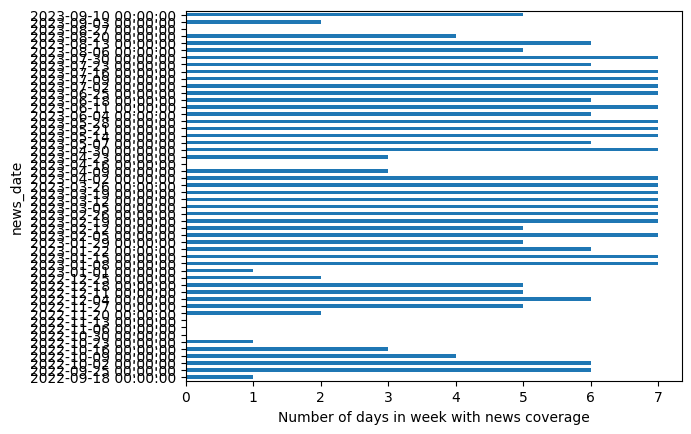

In [9]:
ax = cision_data.groupby('news_date').news_headline.count().resample('W').count().plot.barh(
  xlabel='Number of days in week with news coverage'
)